# Dataset Setup

### Loading and understanding the dataset

In [21]:
import pandas as pd

df = pd.read_csv('cnn_baseline_synthetic_dataset.csv')

In [22]:
print(df.head())

    pixel_1    pixel_2   pixel_3    pixel_4   pixel_5   pixel_6   pixel_7  \
0  1.350530  -0.264931  1.458192 -10.420865 -4.039925  2.285616  0.244955   
1  2.244223   5.408116 -0.018820  -3.599888  1.685529  0.894830 -3.411413   
2  1.030068  -0.521617  0.500427  -8.206938 -2.528794  1.100525 -1.378448   
3 -3.689529  32.855339  1.133847  -3.278487  2.193459  4.124296 -3.366438   
4 -1.327645  23.332569  0.088367  -9.821378 -0.215715  6.561646  1.508672   

    pixel_8   pixel_9   pixel_10  ...  pixel_24  pixel_25  pixel_26  pixel_27  \
0 -1.075668 -1.618843  -9.490431  ...  1.671737 -9.411794  0.297915 -3.652920   
1 -1.039748  2.671037   7.939064  ...  4.399925  2.580795  1.120450 -0.628232   
2 -0.237991 -0.469913  -1.135191  ...  1.137793  2.458394 -0.129610 -0.259983   
3  1.087411 -2.729986   5.768818  ...  4.515693  0.917887 -0.347805  3.542585   
4  0.094761 -0.956521  12.388239  ... -0.147159  1.312556  0.393136 -0.383121   

   pixel_28  pixel_29  pixel_30  pixel_31  pixel_3

In [23]:
print(df.columns)

Index(['pixel_1', 'pixel_2', 'pixel_3', 'pixel_4', 'pixel_5', 'pixel_6',
       'pixel_7', 'pixel_8', 'pixel_9', 'pixel_10', 'pixel_11', 'pixel_12',
       'pixel_13', 'pixel_14', 'pixel_15', 'pixel_16', 'pixel_17', 'pixel_18',
       'pixel_19', 'pixel_20', 'pixel_21', 'pixel_22', 'pixel_23', 'pixel_24',
       'pixel_25', 'pixel_26', 'pixel_27', 'pixel_28', 'pixel_29', 'pixel_30',
       'pixel_31', 'pixel_32', 'label'],
      dtype='object')


In [24]:
print(df.shape)

(1000, 33)


In [25]:
print(df['label'].value_counts())

label
0    102
1    101
5    100
6    100
9    100
3    100
2    100
8     99
7     99
4     99
Name: count, dtype: int64


In [26]:
print(df.dtypes)

pixel_1     float64
pixel_2     float64
pixel_3     float64
pixel_4     float64
pixel_5     float64
pixel_6     float64
pixel_7     float64
pixel_8     float64
pixel_9     float64
pixel_10    float64
pixel_11    float64
pixel_12    float64
pixel_13    float64
pixel_14    float64
pixel_15    float64
pixel_16    float64
pixel_17    float64
pixel_18    float64
pixel_19    float64
pixel_20    float64
pixel_21    float64
pixel_22    float64
pixel_23    float64
pixel_24    float64
pixel_25    float64
pixel_26    float64
pixel_27    float64
pixel_28    float64
pixel_29    float64
pixel_30    float64
pixel_31    float64
pixel_32    float64
label         int64
dtype: object


# Load, Normalize, and Create DataLoader

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from sklearn.preprocessing import StandardScaler

class SyntheticDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        self.X = df.drop('label', axis=1).values 
        self.y = df['label'].values    
        
        # Normalize features using StandardScaler
        scaler = StandardScaler()
        self.X = scaler.fit_transform(self.X)
        
        # Convert to torch tensors
        # Shape X -> (samples, channels=1, features=32)
        self.X = torch.tensor(self.X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(self.y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Instantiate dataset
dataset = SyntheticDataset('cnn_baseline_synthetic_dataset.csv')

# Split into train and test (80-20 split)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")
print(f"Sample input shape: {dataset[0][0].shape}, Sample label: {dataset[0][1]}")


Train samples: 800, Test samples: 200
Sample input shape: torch.Size([1, 32]), Sample label: 5


# Creating the baseline CNN model using pytorch

### using Convolution, ReLU and Max Pooling Layers

In [28]:
import torch.nn.functional as F
import torch.nn as nn

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4, 128)  # After 3 pooling, length reduced to 4
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [29]:
model = BaselineCNN()
print(model)

BaselineCNN(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


# Training Loop 

In [30]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = ImprovedCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

num_epochs = 20  # train longer


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    val_loss = running_loss / total
    val_acc = correct / total
    return val_loss, val_acc

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} - "
          f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")


Epoch 1/20 - Train loss: 2.3052, Train acc: 0.1175 - Val loss: 2.2690, Val acc: 0.1650
Epoch 2/20 - Train loss: 2.1962, Train acc: 0.2087 - Val loss: 2.2465, Val acc: 0.1400
Epoch 3/20 - Train loss: 2.1005, Train acc: 0.2675 - Val loss: 2.1939, Val acc: 0.1800
Epoch 4/20 - Train loss: 1.9881, Train acc: 0.3175 - Val loss: 2.1290, Val acc: 0.2600
Epoch 5/20 - Train loss: 1.8794, Train acc: 0.3738 - Val loss: 2.0974, Val acc: 0.2600
Epoch 6/20 - Train loss: 1.7232, Train acc: 0.4437 - Val loss: 2.0163, Val acc: 0.2850
Epoch 7/20 - Train loss: 1.6244, Train acc: 0.4850 - Val loss: 2.0322, Val acc: 0.2700
Epoch 8/20 - Train loss: 1.5002, Train acc: 0.5088 - Val loss: 2.0090, Val acc: 0.2950
Epoch 9/20 - Train loss: 1.3778, Train acc: 0.5575 - Val loss: 2.0434, Val acc: 0.3000
Epoch 10/20 - Train loss: 1.3052, Train acc: 0.5625 - Val loss: 2.0673, Val acc: 0.2950
Epoch 11/20 - Train loss: 1.1920, Train acc: 0.6238 - Val loss: 2.0000, Val acc: 0.3150
Epoch 12/20 - Train loss: 1.1422, Train a

# Evaluation, Visualization, and Analysis

In [31]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12,5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()

    plt.show()


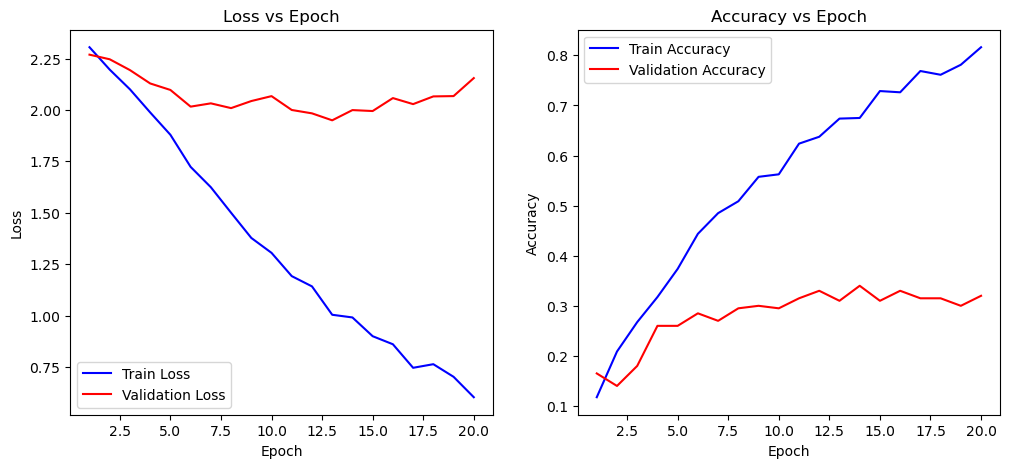

In [33]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


# Plotting the confusion matrix

Test Accuracy: 0.3200


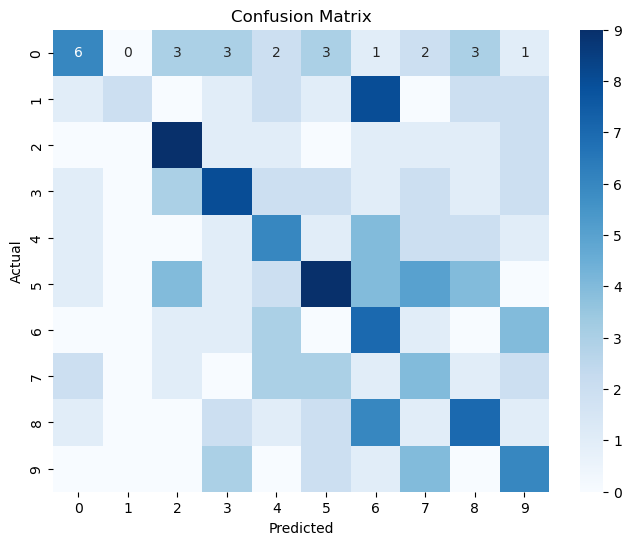

In [34]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Call it with your model and test_loader
evaluate_model(model, test_loader, device)
